<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_6_1_Object_Detection_SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection - Images with multiple objects

* The material for this notebook is taken from the Open Source book -- Dive into Deep Learning. I have adapted a few things for the Computer Vision course at the University of South Florida, Tampa. https://d2l.ai/chapter_computer-vision/ssd.html)

* Much of the code is take from pytorch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
!pip install d2l==0.16.2

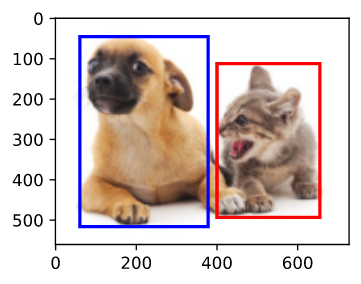

# Bounding Boxes

* Object detection recognizes not only all the objects of interest in the image but also their positions. A rectangular bounding box represents the overall position of the object.

* We can specify these boxes using (i) a center coordinate and (height, width) or (ii) two diagonally opposite corner coordinates.
    * **We need 4 numbers to specify a bounding box.**

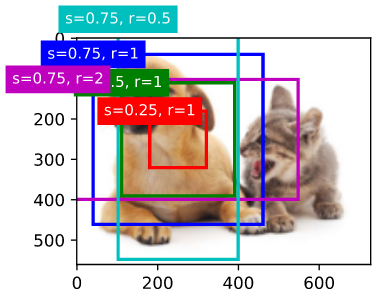

# Anchor Boxes

* We will generate *multiple* bounding box hypotheses with varying scales ($s$) and aspect ratios ($r$) centered on *each* pixel.  These hypothesized bounding boxes are called **anchor boxes**.

* The deep network will learn to select among the many anchor boxes.

## Generating Multiple Anchor Boxes

* For each layer, divide the $(h, w)$ sized activation map into a grid of **center/anchor positions (anchors)**.

* For each layer, define a set of **sizes**, $\{s_1, s_2, \cdots, s_n | s_i\in (0, 1]\}$, and the **aspect ratio** (ratio of width to height), $\{r_1, r_2, \cdots, r_m | r_j > 0 \}$ 

* For each center position (anchors), we associate a set of **anchor boxes** based on the sizes and aspects.
    * To limit the number of anchor boxes, we consider only combinations
containing $s_1$ or $r_1$: $$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1)$$

    * For each combination of size and aspect $(s_i, r_j)$, **the width and height of the anchor box are $ws_i\sqrt{r_j}$ and $hs_i/\sqrt{r_j}$, respectively.**

* For each layer, the number of anchor boxes centered on the same pixel is $n+m-1$. We will generate **a total of $wh(n+m-1)$ anchor boxes**.

* Consider an example. 
    * Let the CNN have 5 layers
    * For each layer of the CNN, we associate two sizes, i.e., $(n=2)$.
    * For 5 layers, we first divide the interval from 0.2 to 1.05 into five equal parts: 0.2, 0.37, 0.54, etc., giving us the **lower size** for each layer.
    * The geometric mean between two of the 5 sizes above: $\sqrt{0.2 \times 0.37} = 0.272$, $\sqrt{0.37 \times 0.54} = 0.447$, etc., gives us the larger anchor boxes at the different sizes for **each of the layers**.


In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]] 
# 2 sizes for each of the 5 layers
print("sizes: ", sizes)

ratios = [[1, 2, 0.5]] * 5  # 3 aspect ratios for each of the 5 layers
print("ratio:  ", ratios)

num_anchors = len(sizes[0]) + len(ratios[0]) - 1

for i in range(5) :
    print('\nAnchor boxes scales/sizes  for layer', i, 'are', sizes[i])
    print('Anchor boxes aspect ratios for layer', i, 'are', ratios[i])
    print('Total  anchors per pixel   for layer', i, 'is', len(sizes[i]) + len(ratios[i]) - 1)


## Code: `multibox_prior`

The above method of generating anchor boxes is implemented in the following `multibox_prior` function. We specify the input image/data, a list of scales/sizes, and aspect ratios, and then this function will return all the anchor box height and width dimensions.

In [ ]:
def multibox_prior (data, sizes, ratios):
    """
    Generates and return anchor boxes with different shapes centered on each pixel in an image
    grid that matches the size of data. 
    Each anchor box is specified by 4 numbers specifying two diagonal corners: 
    [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    """

    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)

    
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis for every pixel
    steps_w = 1.0 / in_width  # Scaled steps in x axis for every pixel

    # Generate all center points for the anchor boxes (normalized to be between 0 and 1)
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
  
    # each shift_y and shift_x is a 2-D array of numbers (mesh) -- change to 1D.
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    

    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))* in_height / in_width  
                   # Handle rectangular inputs aspects
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    # Divide by 2 to get half height and half width and then "tile" the boxes by repeating
    # to span the entire image grid
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], 
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [ ]:
# Generates the anchors for each layer.
Y = torch.zeros ((5, 5)) # image
w, h = Y.shape
anchors = multibox_prior(Y, sizes=sizes[0], ratios=ratios[0])

print('Anchor shape (batch size, number of anchor boxes, 4):', anchors.shape, 
      '\nNumber of anchors:', anchors.shape[1]); 
print('\nNotice the pattern every four rows in the Anchors')
print(' [top_left_x, top_left_y, bottom_right_x, bottom_right_y]:\n', anchors);

* The following changes shape of the anchor boxes to (image height, image width, number of anchor boxes per pixel, 4) so that they can indexed by image pixel coordinates.


* As an example, we access the first anchor box centered on (0, 0). It has four elements: the $(x, y)$-axis coordinates at the upper-left corner and the $(x, y)$-axis coordinates at the lower-right corner of the anchor box.


* The coordinate values of both axes are divided by the width and height of the image, respectively; thus, the range is between 0 and 1.


In [ ]:
print("The previous shape of anchors ", anchors.shape)
boxes = anchors.reshape(w, h, num_anchors, 4)
print("The new shape of anchors ", boxes.shape)
print('The 3rd anchor box at pixel (0, 0): ', boxes[0, 0, 3, :])

In order to **show all the anchor boxes centered on one pixel in the image**,
we define the following `show_bboxes` function to draw multiple bounding boxes on the image.


In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        # change the bbox specification from corner based to a format used by matplotlib
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                      ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [ ]:
from d2l import torch as d2l

fig, axs = plt.subplots(nrows=1, ncols=2, )
fig.set_size_inches (10, 5)
axs[0].set(xlim=(0, 5), ylim=(0, 5))
axs[1].set(xlim=(0, 5), ylim=(0, 5))

bbox_scale = torch.tensor((w, h, w, h))

axs[0].set_title('All 100 anchors in the 5 by 5 image')
for i in range (h) :
    for j in range (w) :
        show_bboxes(axs[0], (boxes[i, j, :, :]) * bbox_scale)

axs[1].set_title('4 anchors for a specific pixel')
show_bboxes(axs[1], (boxes[2, 2, :, :]) * bbox_scale)

# Single Shot Multibox Detection (SSD)

* Single shot multi-box detection
(SSD) [(Liu et al., 2016)](https://arxiv.org/pdf/1512.02325.pdf) is quick and easy model that is widely used. 

* Some of this model's design concepts and implementation details are also applicable to other object detection models. 

* The overall architecture, taken from Liu et al.'s paper, is shown below.

In [ ]:
print('Total number of bounding boxes (feature_size * #anchors): ', 
      (38*38)*4 + (19*19)*6 + (10*10)*6 + (5*5)*6 + (3*3)*4+ 1*4)

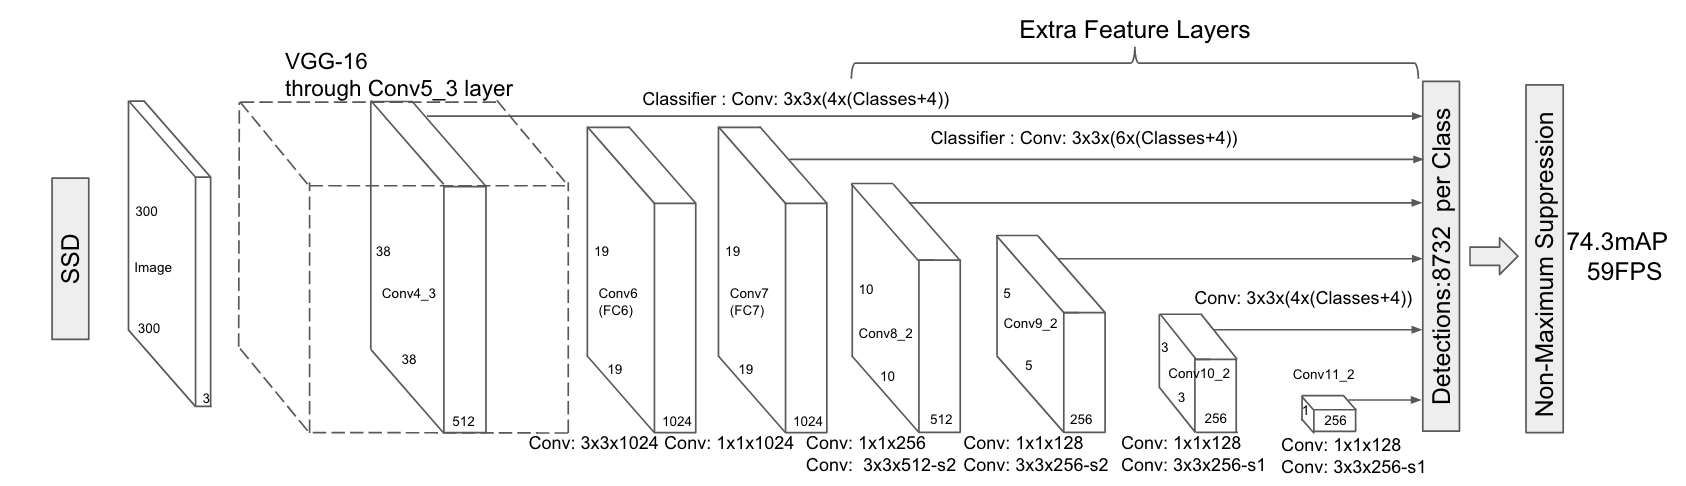

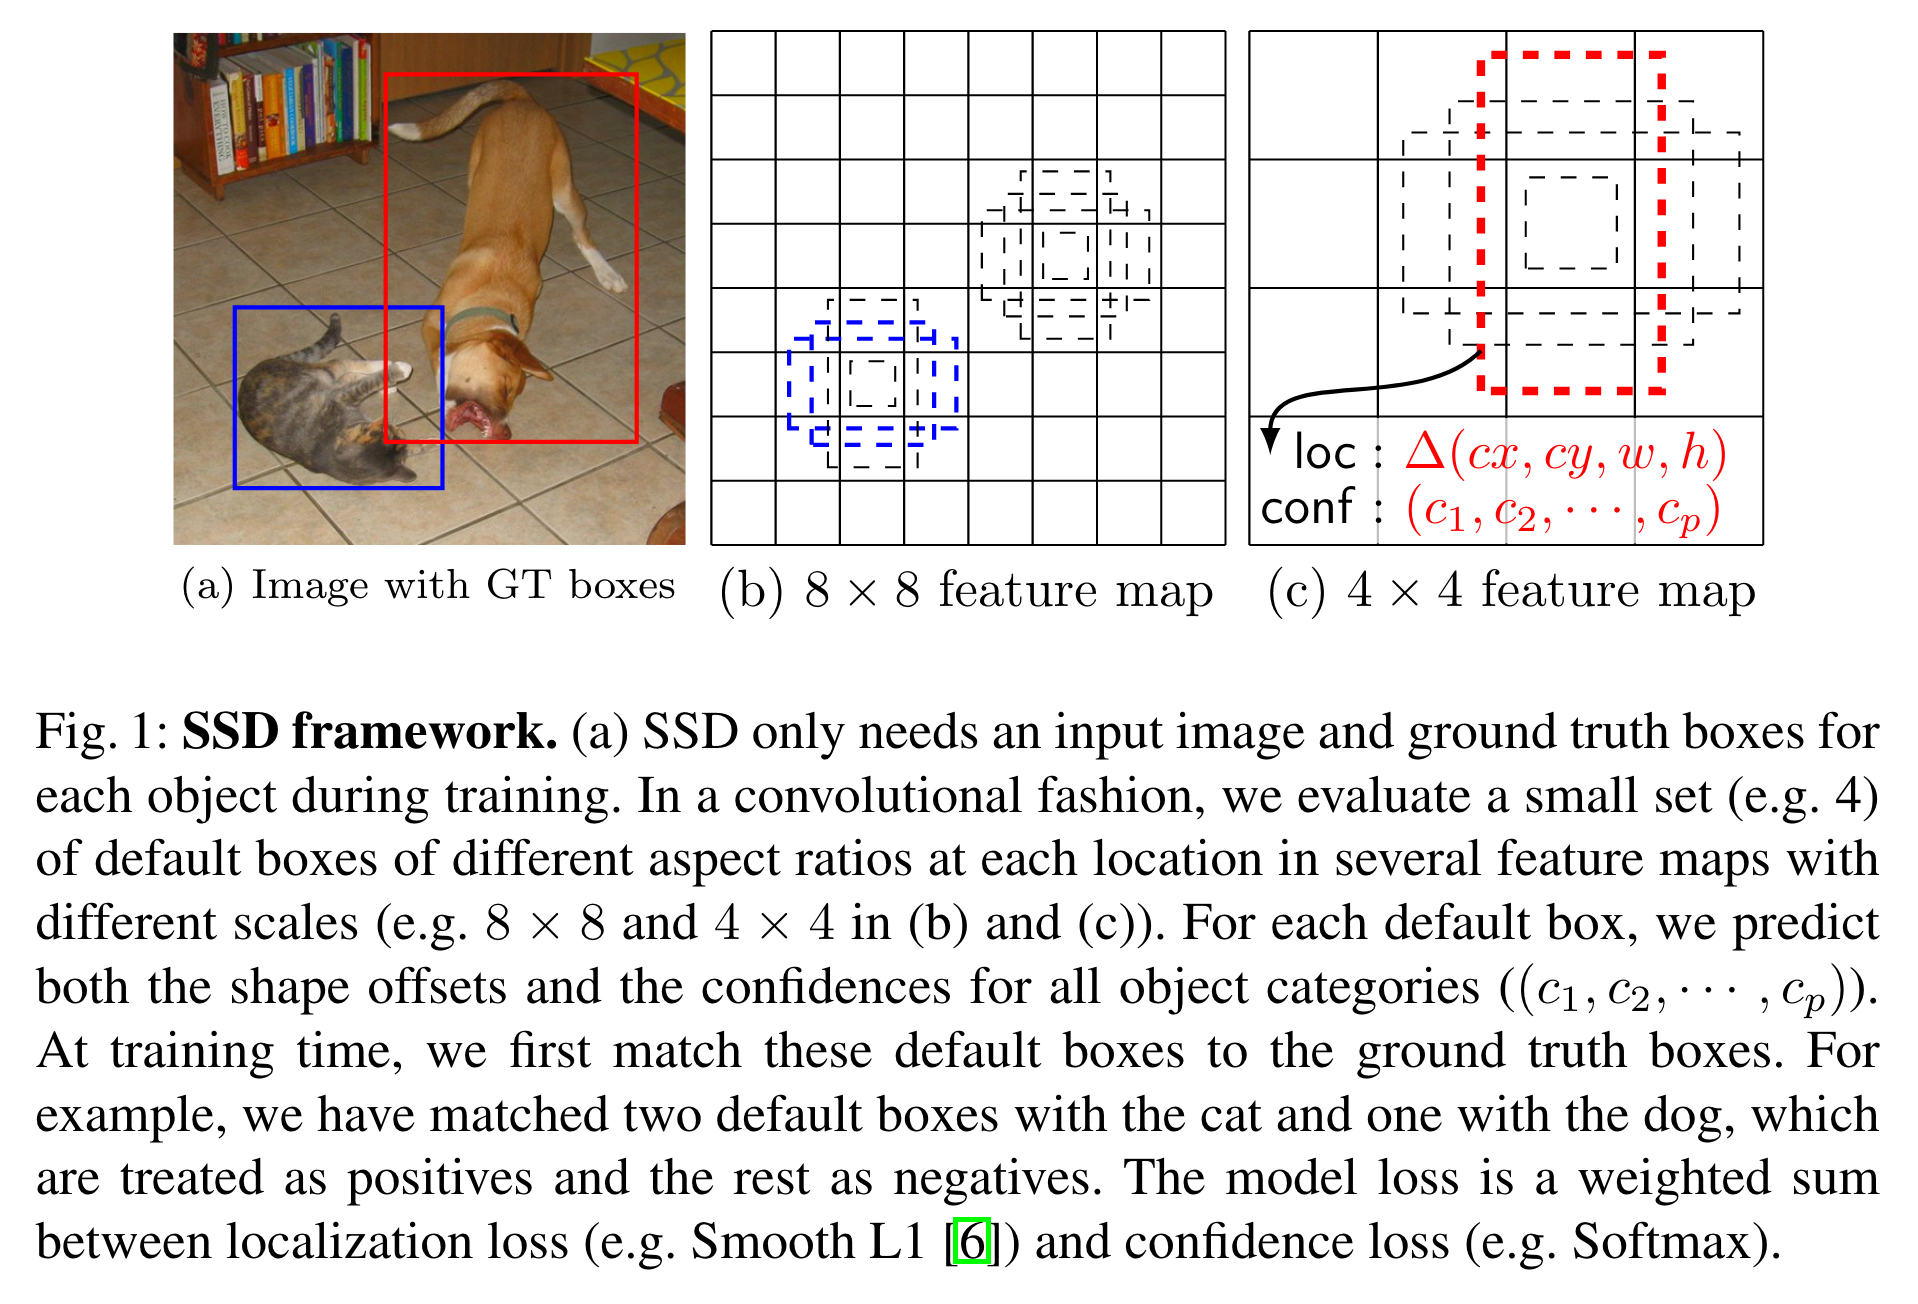

# Code: from PyTorch

* This SSD300 model is based on the SSD: Single Shot MultiBox Detector paper, which describes SSD as “a method for detecting objects in images using a single deep neural network.” The input size is fixed to 300x300.

* The backbone is the main difference between this model and the one described in the paper. Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

* The **COCO dataset** is an excellent object detection dataset with 80 classes, 80,000 training images, and 40,000 validation images. https://cocodataset.org/#home

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'


In [ ]:
import torch

# Load an SSD model pretrained on COCO dataset, 
# as well as a set of utility methods for convenient and comprehensive formatting 
# of input and output of the model.
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', trust_repo=False)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils', trust_repo=False)

#Now, prepare the loaded model for inference
ssd_model.to('cuda')
ssd_model.eval()

# Prepare input images for object detection. (Example links below correspond to 
# first few test images from the COCO dataset, but you can also specify paths to 
# your local images here)
uris = [
    data_dir + 'Wildtrack/C1/00000015.png',
    data_dir + 'Wildtrack/C2/00000015.png',
    data_dir + 'Wildtrack/C3/00000015.png',
    data_dir + 'Wildtrack/C4/00000015.png',
    data_dir + 'Wildtrack/C5/00000015.png',
    data_dir + 'Wildtrack/C6/00000015.png',
    data_dir + 'Wildtrack/C7/00000015.png'
#    'http://images.cocodataset.org/val2017/000000397133.jpg'
#    ,'http://images.cocodataset.org/val2017/000000037777.jpg',
#    'http://images.cocodataset.org/val2017/000000252219.jpg'
    ]

#Format the images to comply with the network input and convert them to tensor.
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs)


# Run the SSD network to perform object detection.
with torch.no_grad():
    detections_batch = ssd_model(tensor)

print('\n SSD output is tuple two entries of sizes (batch_size, #bbox, number), (batch_size, #classes, number):\n', 
      detections_batch[0].shape, detections_batch[1].shape)
print('\n SSD output\n', detections_batch)

# By default, raw output from SSD network per input image contains 8732 boxes 
# with localization and class probability distribution. Let’s filter this output 
# to only get reasonable detections (confidence>40%) in a more comprehensive format.
results_per_input = utils.decode_results(detections_batch)
print('\n After filtering out the non-object/background labels we have (bboxes, labels, confidence)', 
      results_per_input[0][0].shape, results_per_input[0][1].shape, results_per_input[0][2].shape)

# select the most confident ones -- change 0.4 below to see the effect
best_results_per_input = [utils.pick_best(results, 0.4) for results in results_per_input]

# The model was trained on COCO dataset, which we need to access in order to 
# translate class IDs into object names. For the first time, 
# downloading annotations may take a while.
classes_to_labels = utils.get_coco_object_dictionary();

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5 # change the pixels values in (-1, 1) to be in (0, 1)
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()


# Tiny SSD

Below is the design of a tiny SSD model we will implement. The model's main components are a base network block and several multiscale feature blocks connected in a series. Here, the base network block is used to extract features of original images, and it generally takes the form of a deep convolutional neural network.

![The SSD comprises a base network block and several multiscale feature blocks connected in a series. 
](http://d2l.ai/_images/ssd.svg)

* Each multiscale feature block reduces the height and width of the feature map provided by the previous layer (for example, it may reduce the sizes by half). 

* The closer a multiscale feature block is to the bottom, the smaller its output feature map and the larger is the number of anchor boxes generated based on the feature map. 

* The closer a feature block is to the top, the larger the receptive field of each element in the feature map and the better suited it is to detect larger objects. 

* SSD is a **multiscale** object detection model as it generates anchor boxes of different sizes and then predicts the categories and offsets (i.e., predicted bounding boxes)  of the anchor boxes to detect objects of different sizes.

* Before we can look at an implementation, we need to discuss the implementation of category prediction and bounding box prediction.



## Category Prediction Layer

* Let the number of object categories for each bounding box be $q+1$, with 0 indicating an anchor box that only contains background. 

* For each scale, let the height and width of the feature map be denoted by $h$ and $w$, respectively.

* For each location (center) of the feature map, we generate $a$ anchor boxes, so we need to classify **a total of $hwa$ anchor boxes**. 

* SSD uses a convolutional layer to output category prediction to reduce the model complexity. Fully connected layer (FCN) result in an excessive number of model parameters. 

* **Specifically, the category prediction layer uses a convolutional layer that maintains the input height and width.** Thus, the output and input have a one-to-one correspondence to the spatial coordinates along the width and height of the feature map. 

* Assuming that the output and input have the same spatial coordinates $(x, y)$, the channel for the coordinates $(x, y)$ on the output feature map contains the category predictions for all anchor boxes generated **using the input feature map coordinates $(x, y)$ as the center**. 

* Therefore, there are $a(q+1)$ output channels, with the output channels indexed as $i(q+1) + j$ ($0 \leq j \leq q$) representing the predictions of the category index $j$ for the anchor box index $i$.

In summary, the category prediction layer is a $3\times3$ convolutional layer (with a padding of 1) with $a(q+1)$ output channels. The heights and widths of the input and output of this convolutional layer remain unchanged.


In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

## Bounding Box Prediction Layer

The design of the bounding box prediction layer is similar to that of the category prediction layer. The only difference is that, here, we need to predict 4 offsets for each anchor box, rather than $q+1$ categories.


In [ ]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

### Concatenating Predictions for Multiple Scales

* SSD uses feature maps based on multiple scales to generate anchor boxes and predict their categories and offsets. Because the shapes and number of anchor boxes centered on the same element differ for the feature maps of different scales, **the prediction outputs at different scales may have different shapes.**

* In the following example, we use the same batch of data to construct feature maps of two different scales, `Y1` and `Y2`. Here, `Y2` has half the height and half the width of `Y1`. Using category prediction as an example, we assume that each element in the `Y1` and `Y2` feature maps generates five (Y1) or three (Y2) anchor boxes. When there are 10 object categories, the number of category prediction output channels is either $5\times(10+1)=55$ or $3\times(10+1)=33$. The format of the prediction output is (batch size, number of channels, height, width). As you can see, except for the batch size, the sizes of the other dimensions are different. Therefore, we must transform them into a consistent format and concatenate the predictions of the multiple scales to facilitate subsequent computation.


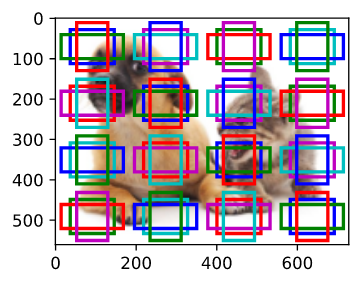

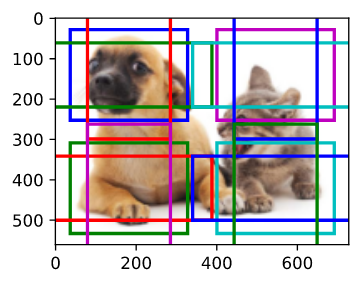

In [ ]:
def forward(x, block):
    return block(x)

# format of input and output dimensions arel (batch size, number of channels, height, width).
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(num_inputs=8, num_anchors=5, num_classes=10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(num_inputs=16, num_anchors=3, num_classes=10))
(Y1.shape, Y2.shape)

* **The channel dimension contains the predictions for all anchor boxes with the same center.** We first move the channel dimension to the final dimension. Because the batch size is the same for all scales, we can convert the prediction results to binary format (batch size, height $\times$ width $\times$ number of channels) to facilitate subsequent concatenation on the $1^{\mathrm{st}}$ dimension.


In [ ]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

Thus, regardless of the different shapes of `Y1` and `Y2`, we can still concatenate the prediction results for the two different scales of the same batch.


In [ ]:
concat_preds([Y1, Y2]).shape

## Height and Width Downsample Block

* We define the **following `down_sample_blk` block for multiscale object detection that reduces the height and width by 50%**. 

* This block consists of **two** $3\times3$ convolutional layers with a padding of 1 and a $2\times2$ maximum pooling layer with a stride of 2 connected in a series. 

    * As we know, $3\times3$ convolutional layers with a padding of 1 do not change the shape of feature maps. However, the subsequent pooling layer directly reduces the size of the feature map by half. 

    * Each element in the output feature map has an effective receptive field on the input feature map of the shape $6\times6$ -- the result of concatation of two $3 \times 3$ convolutions. 
    
* As you can see, the height and width downsample block enlarges the receptive field of each element in the output feature map.


In [ ]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

print(down_sample_blk (3, 10))

* By testing forward computation in the height and width downsample block, we can see that it changes the number of input channels and halves the height and width.


In [ ]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape
 # The above is essentially doing: down_sample_blk(3, 10)(torch.zeros((2, 3, 20, 20))).shape

### Base Network Block

* The base network block is used to extract features from original images. **To simplify the computation, we will construct a small base network.** 

* This network consists of three height and width downsample blocks connected in a series. 

* It doubles the number of channels at each step. 

* For a $256\times256$ image, the base network block outputs a feature map with the shape $32 \times 32$ in 64 channels


In [ ]:
def base_net():
    blk = []
    num_channels = [3, 16, 32, 64]
    for i in range(len(num_channels) - 1):
        blk.append(down_sample_blk(num_channels[i], num_channels[i + 1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

print(base_net())

### The Complete Model

* The SSD model contains a total of five modules. Each module outputs a feature
map used to generate anchor boxes and predict the categories and offsets of
these anchor boxes. 

    * The first module is the base network block

    * Modules two to four are height and width downsample blocks, and

    * fifth module is a global maximum pooling layer that reduces the height and width to 1. 

    * Modules two to five are all multiscale feature blocks.


In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

* Each module returns feature map `Y` output by convolutional computation **and** the current scale's anchor boxes generated from `Y` and their predicted categories and offsets.

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

Now, we can define the complete model, `TinySSD`.


In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]

        
        for i in range(5):
            # The assignment statement is self.blk_i = get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(
                self, f'cls_{i}',
                cls_predictor(idx_to_in_channels[i], num_anchors,
                              num_classes))
            setattr(self, f'bbox_{i}',
                    bbox_predictor(idx_to_in_channels[i], num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i) accesses self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        # In the reshape function, 0 indicates that the batch size remains
        # unchanged
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1,
                                      self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

We now create an SSD model instance and use it to perform forward computation on image minibatch `X`, which has a height and width of 256 pixels. As we verified previously, the first module outputs a feature map with the shape $32 \times 32$. Because modules two to four are height and width downsample blocks, module five is a global pooling layer, and each element in the feature map is used as the center for 4 anchor boxes, a total of $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$ anchor boxes are generated for each image at the five scales.


In [ ]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
Y = net(X)
anchors, cls_preds, bbox_preds = Y

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

print(net)

print(anchors)

## Training

Now, we will explain, step by step, how to train the SSD model for object detection.

### Data Reading and Initialization

We read the banana detection dataset we created in the previous section.


In [ ]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

There is 1 category in the banana detection dataset. After defining the module, we need to initialize the model parameters and define the optimization algorithm.


In [ ]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### Defining Loss and Evaluation Functions

Object detection is subject to two types of losses. The first is anchor box category loss. For this, we can simply reuse the cross-entropy loss function we used in image classification. The second loss is positive anchor box offset loss. Offset prediction is a normalization problem. However, here, we do not use the squared loss introduced previously. Rather, we use the $L_1$ norm loss, which is the absolute value of the difference between the predicted value and the ground-truth value. The mask variable `bbox_masks` removes negative anchor boxes and padding anchor boxes from the loss calculation. Finally, we add the anchor box category and offset losses to find the final loss function for the model.


In [ ]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

We can use the accuracy rate to evaluate the classification results. As we use the $L_1$ norm loss, we will use the average absolute error to evaluate the bounding box prediction results.


In [ ]:
def cls_eval(cls_preds, cls_labels):
    # Because the category prediction results are placed in the final
    # dimension, argmax must specify this dimension
    return float(
        (cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

### Training the Model

During model training, we must generate multiscale anchor boxes (`anchors`) in the model's forward computation process and predict the category (`cls_preds`) and offset (`bbox_preds`) for each anchor box. Afterwards, we label the category (`cls_labels`) and offset (`bbox_labels`) of each generated anchor box based on the label information `Y`. Finally, we calculate the loss function using the predicted and labeled category and offset values. To simplify the code, we do not evaluate the training dataset here.


In [ ]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # accuracy_sum, mae_sum, num_examples, num_labels
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict the category and
        # offset of each
        anchors, cls_preds, bbox_preds = net(X)
        # Label the category and offset of each anchor box
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled
        # category and offset values
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
    
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

## Prediction

In the prediction stage, we want to detect all objects of interest in the image. Below, we read the test image and transform its size. Then, we convert it to the four-dimensional format required by the convolutional layer.


In [ ]:
X = torchvision.io.read_image('/data/banana-detection/bananas_val/images/5.png').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

Using the `multibox_detection` function, we predict the bounding boxes based on the anchor boxes and their predicted offsets. Then, we use non-maximum suppression to remove similar bounding boxes.


In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

Finally, we take all the bounding boxes with a confidence level of at least 0.9 and display them as the final output.


In [ ]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'r')

display(img, output.cpu(), threshold=0.05)

# Summary

* SSD is a multiscale object detection model. This model generates different numbers of anchor boxes of different sizes based on the base network block and each multiscale feature block and predicts the categories and offsets of the anchor boxes to detect objects of different sizes.
* During SSD model training, the loss function is calculated using the predicted and labeled category and offset values.


# Advanced Material

## Loss Function

A. For the predicted offsets, replace $L_1$ norm loss with $L_1$ regularization loss. This loss function uses a square function around zero for greater smoothness. This is the regularized area controlled by the hyperparameter $\sigma$:

$$
f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \text{if }|x| < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \text{otherwise}
    \end{cases}
$$

When $\sigma$ is large, this loss is similar to the $L_1$ norm loss. When the value is small, the loss function is smoother.

In [ ]:
def smooth_l1(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar**2):
            out.append(((scalar * i)**2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar**2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)
d2l.plt.legend();

In the experiment, we used cross-entropy loss for category prediction. Now,
assume that the prediction probability of the actual category $j$ is $p_j$ and
the cross-entropy loss is $-\log p_j$. We can also use the **focal loss**
[(Lin et al., 2017)](https://openaccess.thecvf.com/content_ICCV_2017/papers/Lin_Focal_Loss_for_ICCV_2017_paper.pdf). Given the positive hyperparameters $\gamma$
and $\alpha$, this loss is defined as:

$$ - \alpha (1-p_j)^{\gamma} \log p_j.$$

As you can see, by increasing $\gamma$, we can effectively reduce the loss when the probability of predicting the correct category is high.


In [ ]:
def focal_loss(gamma, x):
    return -(1 - x)**gamma * torch.log(x)

x = torch.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
d2l.plt.legend();

### Training and Prediction

B. When an object is relatively large compared to the image, the model normally adopts a larger input image size.

C. This generally produces a large number of negative anchor boxes when labeling anchor box categories. We can sample the negative anchor boxes to better balance the data categories. To do this, we can define a `negative_mining_ratio` parameter in the `multibox_target` function.

D. Assign hyperparameters with different weights to the anchor box category loss and positive anchor box offset loss in the loss function.

E. Refer to the SSD paper. What methods can be used to evaluate the precision of object detection models :cite:`Liu.Anguelov.Erhan.ea.2016`?
